In [87]:
import pandas as pds
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow
import tqdm
import skimage.io
import glob
from skimage.io import imread, imshow
from skimage.transform import resize
import PIL
from sklearn.utils import shuffle
import cv2
import matplotlib.patches as patches
import json

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline

In [88]:
image_dir = 'dataset/input_images/'
image_add = [os.path.join(image_dir, img) for img in os.listdir(image_dir)]


In [89]:
mask_img_list = os.listdir('dataset\input_images_mask')
df_mask_images = pds.DataFrame(mask_img_list, columns=['image_id'])

print('size: ', df_mask_images.size)
df_mask_images.head(10)

size:  50


,image_id
0,ISIC_0024306_segmentation.png
1,ISIC_0024307_segmentation.png
2,ISIC_0024308_segmentation.png
3,ISIC_0024309_segmentation.png
4,ISIC_0024310_segmentation.png
5,ISIC_0024311_segmentation.png
6,ISIC_0024312_segmentation.png
7,ISIC_0024313_segmentation.png
8,ISIC_0024314_segmentation.png
9,ISIC_0024315_segmentation.png


In [90]:
img_list = os.listdir('dataset\input_images')
df_images = pds.DataFrame(img_list, columns=['image_id'])

print('size: ', df_images.size)
df_images.head(10)

size:  50


,image_id
0,ISIC_0024306.jpg
1,ISIC_0024307.jpg
2,ISIC_0024308.jpg
3,ISIC_0024309.jpg
4,ISIC_0024310.jpg
5,ISIC_0024311.jpg
6,ISIC_0024312.jpg
7,ISIC_0024313.jpg
8,ISIC_0024314.jpg
9,ISIC_0024315.jpg


In [91]:
# Initialize empty lists to store images and masks
image = []
binary_mask = []
not_found_imgs = []
cocojson_mask = 'dataset/output/input_images.json'


# Paths to the image and mask directories
data_path = 'dataset/input_images/'
mask_path = 'dataset/input_images_mask/'

# Starting index for images
start_val = 24306

# Size of the dataset
size = start_val + 49
i=start_val 

# Loop through the range of images
while i <= size:
    # Convert the index to a string and calculate the number of zeroes to prepend
    num = str(i)
    zeroes = 7 - len(num)

    # Load the binary mask for the current image
    mask_image = glob.glob(f"{mask_path}*ISIC_{zeroes * '0'}{i}_segmentation.png")
    if mask_image:
        # The mask image is found
        mask_image = mask_image[0]
        mask = cv2.imread(mask_image)
        # Resize the mask to (128, 128)
        mask = cv2.resize(mask, (128, 128))
        binary_mask.append(mask)
    else:
        # If mask is not found, add the image index to the not_found_imgs list
        not_found_imgs.append(i)

    # Load the image
    img_path = f"{data_path}ISIC_{zeroes * '0'}{i}.jpg"
    img = cv2.imread(img_path)
    if type(img) is np.ndarray:
        # Resize the image to (128, 128) if it is a valid image
        img = cv2.resize(img, (128, 128))
        image.append(img)
        print(i)
    i+=1
# Convert the lists to numpy arrays
binary_mask = np.array(binary_mask)
image = np.array(image)

# Print the number of images loaded and any images not found
print(len(image))
print("Completed")
print("Images Not Found:", not_found_imgs)


24306
24307
24308
24309
24310
24311
24312
24313
24314
24315
24316
24317
24318
24319
24320
24321
24322
24323
24324
24325


24326
24327
24328
24329
24330
24331
24332
24333
24334
24335
24336
24337
24338
24339
24340
24341
24342
24343
24344
24345
24346
24347
24348
24349
24350
24351
24352
24353
24354
24355
50
Completed
Images Not Found: []


In [92]:
len(binary_mask)+len(image)

100

In [93]:
def RGBimshow(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)

In [94]:
# Load annotations from the JSON file
with open(cocojson_mask , 'r') as f:
    annotations = json.load(f)

In [95]:


def display_image_with_coco_annotations(image_path, annotations, display_type='both', colors=None):
    # Create a single subplot for displaying the image
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
   
    # Load and display the image
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    ax.imshow(image)
    ax.axis('on')

    # Find the image ID for the current image path
    img_filename = os.path.basename(image_path)
    img_id = next(item['id'] for item in annotations['images'] if item["file_name"] == img_filename)
    
    # Get the annotations for the current image ID
    img_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == img_id]
    
    # Iterate over each annotation and display bounding boxes or segmentations
    for ann in img_annotations:
        if display_type in ['bbox', 'both']:
            bbox = ann['bbox']
            ax.add_patch(patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='black', facecolor='none'))
        
        if display_type in ['seg', 'both']:
            for seg in ann['segmentation']:
                poly = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
                ax.add_patch(patches.Polygon(poly, closed=True, edgecolor='black', fill=False))
                    
    plt.show()


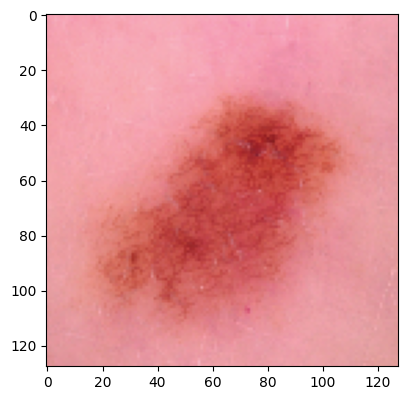

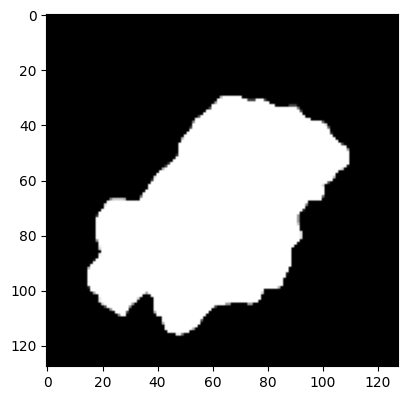

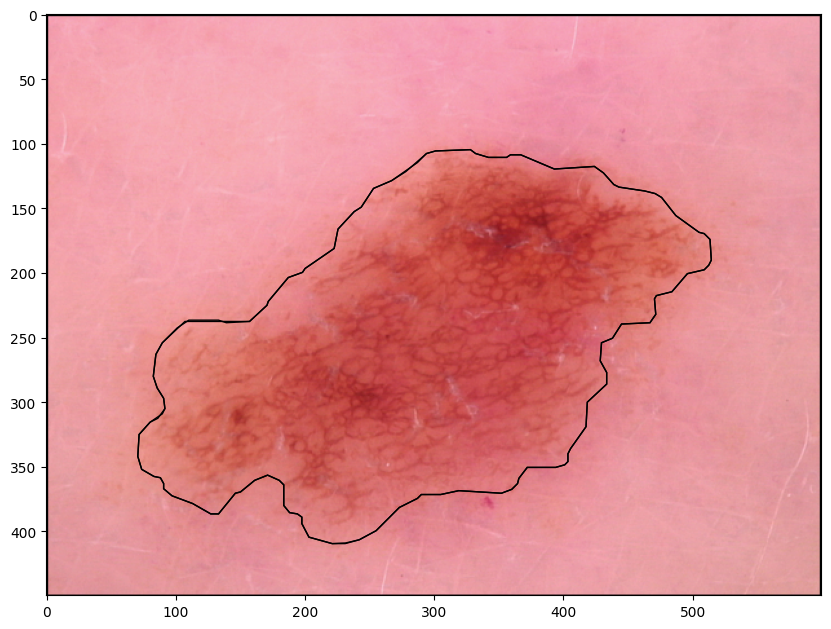

In [96]:
i=5
plt.rcParams['figure.figsize'] = [10, 5]
plt.figure(1)
plt.subplot(1,2,1)
RGBimshow(image[i])
plt.figure(2)
plt.subplot(1,2,1)
plt.rcParams['figure.figsize'] = [10, 5]
plt.imshow(binary_mask[i])


    
# Display image with COCO annotations
display_image_with_coco_annotations(image_add[i], annotations, 'seg')



# Model

In [97]:
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from tensorflow.keras.layers import Concatenate, MaxPooling2D, Lambda,Input, MaxPool2D, Dense, BatchNormalization, LeakyReLU, Conv2D, UpSampling2D, Reshape, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from keras import backend as K
from tensorflow.keras.layers import Convolution2DTranspose, UpSampling2D, Dropout, Conv2DTranspose
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

In [98]:

def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape (None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)



In [99]:
def res_conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
        #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path


In [100]:
def gating_signal(input, out_size, batch_norm=False):
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

In [101]:
def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3), strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]), padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

In [102]:
def encoder_block(inputs, filter_size, filter_num, dropout_rate, batch_norm):
    conv = res_conv_block(inputs, filter_size, filter_num, dropout_rate, batch_norm)
    pool = layers.MaxPooling2D(pool_size=(2,2))(conv)
    return conv, pool

In [103]:
def decoder_block(input, conv, filter_size, filter_num, dropout_rate, batch_norm, up_samp_size, axis):
    gating = gating_signal(input, filter_num, batch_norm)
    att = attention_block(conv, gating, filter_num)
    up = layers.UpSampling2D(size=(up_samp_size, up_samp_size), data_format="channels_last")(input)
    up = layers.concatenate([up, att], axis=axis)
    up_conv = res_conv_block(up, filter_size, filter_num, dropout_rate, batch_norm)
    return up_conv

In [104]:
def Attention_Res_UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):

    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers (Encoder Block)
    conv_128, pool_64 = encoder_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    conv_64, pool_32 = encoder_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    conv_32, pool_16 = encoder_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    conv_16, pool_8 = encoder_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)

    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers (Decoder Block)
    up_conv_16 = decoder_block(conv_8, conv_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm, UP_SAMP_SIZE, axis)
    up_conv_32 = decoder_block(up_conv_16, conv_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm, UP_SAMP_SIZE, axis)
    up_conv_64 = decoder_block(up_conv_32, conv_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm, UP_SAMP_SIZE, axis)
    up_conv_128 = decoder_block(up_conv_64, conv_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm, UP_SAMP_SIZE, axis)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  # Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model

In [105]:
input_shape = (128,128,3)
model = Attention_Res_UNet(input_shape)
model.summary()

Model: "AttentionResUNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_162 (Conv2D)         (None, 128, 128, 64)         1792      ['input_5[0][0]']             
                                                                                                  
 batch_normalization_124 (B  (None, 128, 128, 64)         256       ['conv2d_162[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_104 (Activation  (None, 128, 128, 64)         0         ['batch_normali

In [106]:
s=max([image.shape[0]])
img=[]
mask=[]
y = []
for i in range(s):
  try:
    img.append(image[i])
    mask.append(binary_mask[i][:, :, 0:1])
    y.append([0, 1, 0])
  except:
    pass
img = np.array(img)
mask = np.array(mask)
mask = mask.astype(bool)
y = np.array(y)

In [107]:
mask.shape

(50, 128, 128, 1)

In [108]:
from tensorflow import keras

In [109]:
call= tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience =5, restore_best_weights= True)

In [110]:
arr=[]
class CustomCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    arr.append(self.predict(img[1:2].reshape(128,128)))

In [111]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),loss='binary_crossentropy', metrics=['accuracy'])

In [113]:
history=model.fit(x=img, y=mask, epochs = 50)

Epoch 1/50


KeyboardInterrupt: 